# Earthworks: Modeling Coastal Infrastructure

Brendan Harmon  
2025-07-06

<figure>
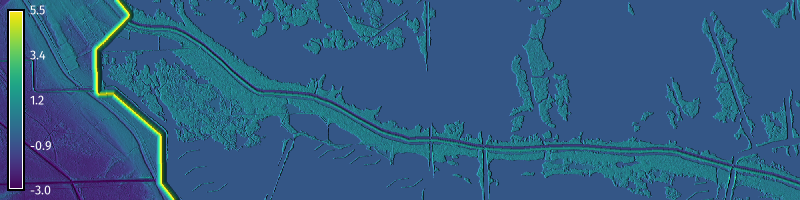
<figcaption aria-hidden="true">Levee improvement &amp; ridge
restoration</figcaption>
</figure>

Learn the how to model levees and ridges with
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html).
Download the [Bayou L’Ours
Dataset](https://doi.org/10.5281/zenodo.15870441). The coordinate
reference system for this project is Louisiana State Plane South in
meters. We will model two of the coastal infrastructure projects in the
Louisiana Coastal Protection and Restoration Authority’s [2023 Coastal
Masterplan](https://coastal.la.gov/wp-content/uploads/2023/06/230531_CPRA_MP_Final-for-web_spreads.pdf).
Improvements are planned to the [Larose to Golden Meadow Levee
System](https://coastal.la.gov/wp-content/uploads/masterplan/111_Larose-to-Golden-Meadow.pdf)
which will raise existing earthen levees to an elevation between 3.6-6.4
meters NAVD88. The [Bayou L’Ours Ridge
Restoration](https://coastal.la.gov/wp-content/uploads/masterplan/334_Bayou-LOurs-Ridge-Restoration.pdf)
project will restore the natural levee by closing gaps, rebuilding
landforms, and reforesting uplands. While the improved levee system will
better protect the towns, the restored ridge will attenuate storm surge.

> **Computational notebook**
>
> This tutorial can be run as a [computational
> notebook](https://grass-tutorials.osgeo.org/content/tutorials/earthworks/levees.ipynb).
> Learn how to work with notebooks in the tutorial [Get started with
> GRASS & Python in Jupyter
> Notebooks](./get_started/fast_track_grass_and_python.qmd).

# Setup

## Project

Download and unarchive the 
[Bayou L'Ours Dataset](https://doi.org/10.5281/zenodo.15870441). 
Then start a GRASS session in the Bayou L'Ours project. 
Since the dataset is approximately 120MB, 
it may take a couple minutes to download.

In [1]:
# Import libraries
import os
import sys
import subprocess
from pathlib import Path
import urllib.request
from zipfile import ZipFile

# Find GRASS Python packages
sys.path.append(
  subprocess.check_output(
    ["grass", "--config", "python_path"],
    text=True
    ).strip()
  )

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Set GRASS database
gisdbase = os.path.join(Path.home(), "grassdata")

# Download dataset
url = "https://zenodo.org/records/15870442/files/bayou_lours.zip?download=1"
filepath = os.path.join(gisdbase, "bayou_lours.zip")
try:
    urllib.request.urlretrieve(url, filepath)
except Exception as e:
    print(f"Error downloading file: {e}")

# Unarchive dataset
with ZipFile(filepath, 'r') as archive:
    archive.extractall(gisdbase)

# Delete archive
os.remove(filepath)

# Start GRASS in Bayou L'Ours project
session = gj.init(Path(gisdbase, "bayou_lours"))

## Installation

Install
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html)
with
[g.extension](https://grass.osgeo.org/grass-stable/manuals/g.extension.html).

In [2]:
# Install extension
gs.run_command("g.extension", extension="r.earthworks")

## Region

Use
[g.region](https://grass.osgeo.org/grass-stable/manuals/g.region.html)
to set the extent and resolution of the computational region.

In [3]:
# Set region
gs.run_command("g.region", n=105100, s=102600, w=1105000, e=1115000, res=5)

# Existing Conditions

Use hillshading, flood simulations, and data from the Louisiana Coastal
Protection and Restoration Authority to visualize the existing
conditions and the proposed plans for coastal infrastructure. The
existing ring levee system - in the west of our study area - protects
the communities of Larose, Cutoff, Galliano, and Golden Meadow along
Bayou Lafourche. This section of the levee is between 4.5-5 meters high.
It may be raised as high as 6.4 meters to provide protection from
100-storms. The alluvial ridge along Bayou L’Ours - which runs through
the middle of our study area - has eroded, subsided, and been cut apart
by oil and gas exploration canals. The gaps should be closed with sheet
pile structures, the ridge rebuilt to an elevation of 1.5 meters NAVD88,
and its uplands reforested. Once restored this natural levee would
attenuate storm surge and provide upland coastal habitat.

## Imagery

Use
[r.relief](https://grass.osgeo.org/grass-stable/manuals/r.relief.html)
for hillshading and
[d.shade](https://grass.osgeo.org/grass-stable/manuals/d.shade.html) to
drape the imagery over the hillshade. Adjust the `brighten` parameter to
better illuminate the map.

In [4]:
# Model relief
gs.run_command("r.relief", input="elevation", output="relief", zscale=10)

# Display imagery
m = gj.Map(width=800)
m.d_shade(shade="relief", color="imagery", brighten=36)
m.show()
m.save("images/levees_01.webp")

<figure>
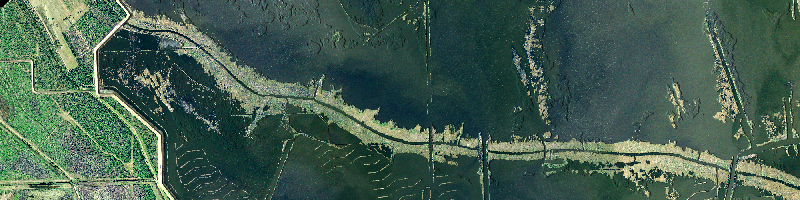
<figcaption aria-hidden="true">Imagery</figcaption>
</figure>

## Terrain

Use [d.shade](https://grass.osgeo.org/grass-stable/manuals/d.shade.html)
to drape the elevation over the hillshade.

In [5]:
# Display elevation
m = gj.Map(width=800)
m.d_shade(shade="relief", color="elevation", brighten=36)
m.d_legend(raster="elevation", digits=0, color="white", at=(5, 95, 1, 3))
m.show()
m.save("images/levees_02.webp")

<figure>
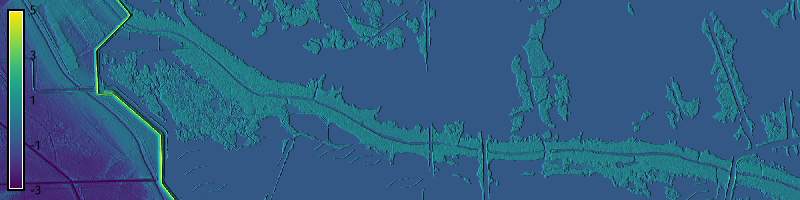
<figcaption aria-hidden="true">Terrain</figcaption>
</figure>

## Flood Simulation

Use [r.lake](https://grass.osgeo.org/grass-stable/manuals/r.lake.html)
to model inundation from storm surge. Set the water level to one meter
and the coordinates to `1109000, 102750`. The simulation will show that
the degraded ridge would be overtopped by a meter of surge.

In [6]:
# Simulate flooding
gs.run_command(
    "r.lake",
    elevation="elevation",
    water_level=1,
    lake="flooding",
    coordinates=[1109000, 102750]
    )

# Display flooding
m = gj.Map(width=800)
m.d_shade(shade="relief", color="elevation", brighten=36)
m.d_rast(map="flooding")
m.d_legend(raster="flooding", digits=1, color="white", at=(5, 95, 1, 3))
m.show()
m.save("images/levees_03.webp")

<figure>
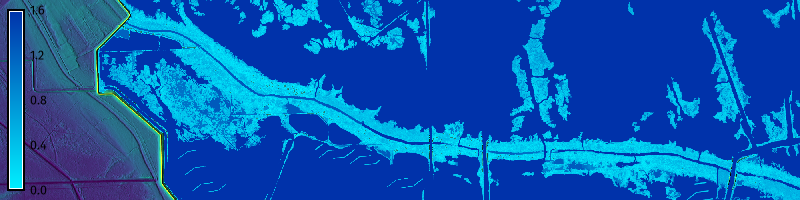
<figcaption aria-hidden="true">Flood simulation</figcaption>
</figure>

## Coastal Restoration

Map the proposed coastal infrastructure projects. Layer the vector maps
of proposed ridge restoration, levee improvement, and gap closure
projects over the shaded relief.

In [7]:
# Display projects
m = gj.Map(width=800)
m.d_shade(shade="relief", color="elevation", brighten=36)
m.d_vect(map="levees", color="white", width=4)
m.d_vect(map="ridges", color="yellow", width=4)
m.d_vect(map="gaps", icon="basic/pin_dot", size=25, color="white", fill_color="white")
m.d_text(text="Levee improvement", color="white", size=7, at=(22,10))
m.d_text(text="Ridge restoration", color="yellow", size=7, at=(34,65))
m.d_text(text="Gap closure", color="white", size=7, at=(49,10))
m.show()
m.save("images/levees_04.webp")

<figure>
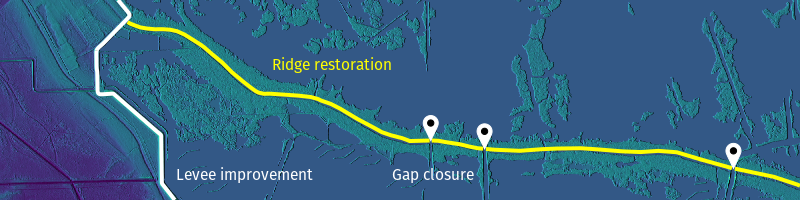
<figcaption aria-hidden="true">Coastal restoration and protection
projects</figcaption>
</figure>

# Ridge Restoration

Use
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html)
to model the restored ridge and the borrow needed to build it. 
The restored ridge should have
a crest elevation of 1.5 meters,
a crest width of 15.2 meters,
and 20% slopes with a ratio of 5H:1V,
i.e. a horizontal run of 5 meters
for a vertical rise of 1 meter.
The soil to rebuild the ridge
should be taken onsite 
from an adjacent borrow area
that would be offset by 7.6 meters 
from the foot of the ridge. 

## Borrow Area

Start by modeling the borrow area - 
an excavation for sourcing material for construction -
needed to restore the ridge.
To model the borrow area,
offset the proposed ridge
and then perform a cut operation.
First use
[v.transform](https://grass.osgeo.org/grass-stable/manuals/v.transform.html)
to shift the vector map of the proposed ridgeline 36 meters to the
north. Then use a cut operation with
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html)
to model the borrow area. Set `elevation` to the elevation raster,
`lines` to the borrow vector, `z` to -1.5, `linear` to 0.2, and `flat` to
7.6.

In [8]:
# Shift ridgeline
gs.run_command("v.transform", input="ridges", output="borrow", yshift=36)

# Model borrow
gs.run_command(
    "r.earthworks",
    elevation="elevation",
    earthworks="earthworks",
    operation="cut",
    lines="borrow",
    z=[-1.5],
    linear=0.2,
    flat=7.6
    )

# Visualize
m = gj.Map(width=800)
m.d_rast(map="earthworks")
m.d_legend(raster="earthworks", color="white", at=(5, 95, 1, 3))
m.show()
m.save("images/levees_05.webp")

<figure>
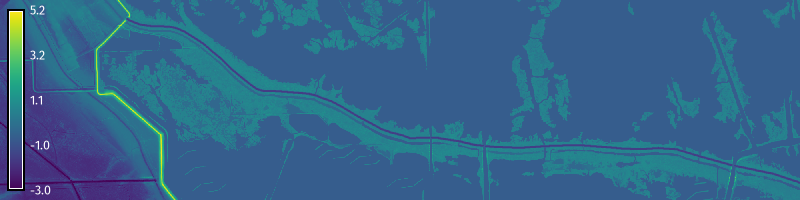
<figcaption aria-hidden="true">Borrow area</figcaption>
</figure>

## Ridge

Use a fill operation with
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html)
to model the restored ridge. Set `elevation` to the earthworks raster,
`lines` to the ridge vector, `z` to 1.5, `linear` to 0.2, and `flat` to
7.6.

In [9]:
# Model ridges
gs.run_command(
    "r.earthworks",
    elevation="earthworks",
    earthworks="earthworks",
    operation="fill",
    lines="ridges",
    z=1.5,
    linear=0.2,
    flat=7.6
    )

# Visualize
m = gj.Map(width=800)
m.d_rast(map="earthworks")
m.d_legend(raster="earthworks", color="white", at=(5, 95, 1, 3))
m.show()
m.save("images/levees_06.webp")

<figure>
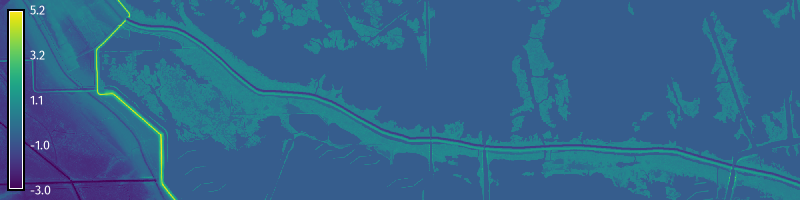
<figcaption aria-hidden="true">Ridge restoration</figcaption>
</figure>

# Levees

Use a fill operation with
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html)
to model the improved levee. The improved levee should have a crest
elevation of 5.5 meters, a crest width of 1.5 meters, and 10% slopes
with a ratio of 10H:1V. For
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html)
set `elevation` to the earthworks raster, `lines` to the levee vector,
`z` to 5.5, `linear` to 0.1, and `flat` to 1.5.

In [10]:
# Model levees
gs.run_command(
    "r.earthworks",
    elevation="earthworks",
    earthworks="earthworks",
    operation="fill",
    lines="levees",
    z=5.5,
    linear=0.1,
    flat=1.5
    )

# Visualize
m = gj.Map(width=800)
m.d_rast(map="earthworks")
m.d_legend(raster="earthworks", color="white", at=(5, 95, 1, 3))
m.show()
m.save("images/levees_07.webp")

<figure>
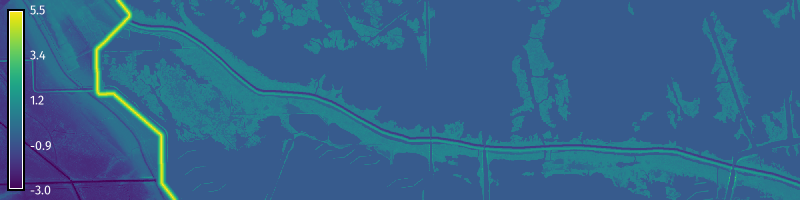
<figcaption aria-hidden="true">Levee improvement</figcaption>
</figure>

# Gap Closure

Use a fill operation with
[r.earthworks](https://grass.osgeo.org/grass-stable/manuals/addons/r.earthworks.html)
to model gap closures with sheet pile structures. 
These structures are walls 
built from rows of interlocking vertical segments 
of piles that are driven into the ground. 
Set `elevation` to the
earthworks raster, `lines` to the gaps vector, `z` to -0.6, `linear` to 1,
and `flat` to 10. The radius of flats should be set to the region
resolution to ensure that the gaps are fully closed because we test our
design with a flood simulation. To better visualize the results, use
[r.relief](https://grass.osgeo.org/grass-stable/manuals/r.relief.html)
and [d.shade](https://grass.osgeo.org/grass-stable/manuals/d.shade.html)
for hillshading.

In [11]:
# Model gaps
gs.run_command(
    "r.earthworks",
    elevation="earthworks",
    earthworks="earthworks",
    operation="cutfill",
    lines="gaps",
    z=-0.6,
    linear=1,
    flat=10
    )

# Model gap closures
gs.run_command(
    "r.earthworks",
    elevation="earthworks",
    earthworks="earthworks",
    operation="cutfill",
    lines="closures",
    z=1.37,
    linear=1,
    flat=5
    )

# Model relief
gs.run_command("r.relief", input="earthworks", output="relief", zscale=10)

# Visualize
m = gj.Map(width=800)
m.d_shade(shade="relief", color="earthworks", brighten=36)
m.d_legend(raster="earthworks", color="white", at=(5, 95, 1, 3))
m.show()
m.save("images/levees_08.webp")

<figure>
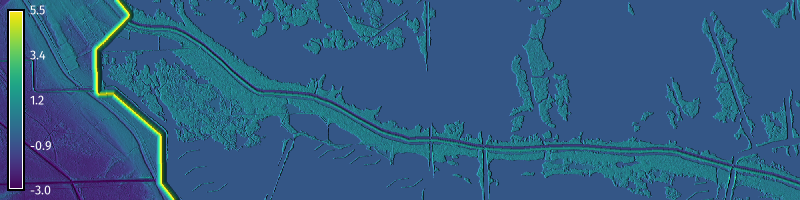
<figcaption aria-hidden="true">Gap closure</figcaption>
</figure>

# Flood Simulation

Test proposed coastal infrastructure with simulated storm surge. Use
[r.lake](https://grass.osgeo.org/grass-stable/manuals/r.lake.html) to
model inundation from storm surge over the earthworks raster. Set the
water level to one meter and the coordinates to `1109000, 102750`. The
simulation will show that the restored ridge with closed gaps would be
not overtopped by a meter of surge.

In [12]:
# Simulate flooding
gs.run_command(
    "r.lake",
    elevation="earthworks",
    water_level=1,
    lake="flooding",
    coordinates=[1109000,102750]
    )

# Visualize
m = gj.Map(width=800)
m.d_shade(shade="relief", color="earthworks", brighten=36)
m.d_rast(map="flooding")
m.d_legend(raster="flooding", digits=1, color="white", at=(5, 95, 1, 3))
m.show()
m.save("images/levees_09.webp")

<figure>
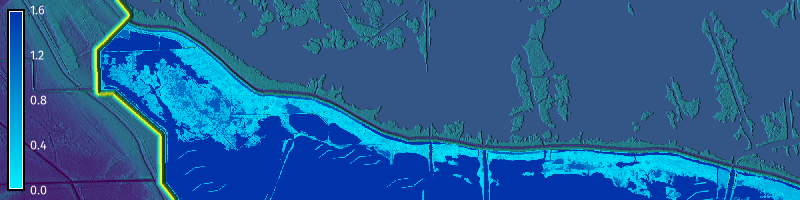
<figcaption aria-hidden="true">Flood simulation</figcaption>
</figure>